## Pipeline

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

from lightgbm import LGBMClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import classification_report, confusion_matrix, \
                            roc_auc_score, accuracy_score, ConfusionMatrixDisplay, \
                            roc_curve, precision_recall_curve

import pickle
import warnings
warnings.filterwarnings("ignore")

In [2]:
def evaluate_model(ytest, ypred, ypred_proba = None):
    if ypred_proba is not None:
        print('ROC-AUC score of the model: {}'.format(roc_auc_score(ytest, ypred_proba[:, 1])))
    print('Accuracy of the model: {}\n'.format(accuracy_score(ytest, ypred)))
    print('Classification report: \n{}\n'.format(classification_report(ytest, ypred)))
    print('Confusion matrix: \n{}\n'.format(confusion_matrix(ytest, ypred)))

### Modelaje

In [3]:
df = pd.read_csv('df_target.csv')
df = df[['lemma', 'label.1']]

In [4]:
# Separamos en train y test
X_train, X_test, y_train, y_test = train_test_split(df.lemma, df['label.1'], test_size=0.2, random_state=123)

In [5]:
# Montamos Pipeline y escogemos los hyperparametros que queremos buscar con GridSearchCV
pipeline = Pipeline(
    [
        ("tfidf", TfidfVectorizer()),
        ("clf", LGBMClassifier()),
    ]
)

parameters = {
    "tfidf__max_df": (0.75, 0.85, 0.95, None),
    "tfidf__min_df": (None, 0.05, 0.1),
    "tfidf__ngram_range": ((1, 1), (1, 2)),  # unigrams or bigrams
    "tfidf__norm": ("l1", "l2"),
    "clf__boosting_type": ("gbdt", "dart", "goss"),
    "clf__max_depth": (20, 30)
}

grid_search = GridSearchCV(pipeline, parameters, n_jobs=-1, verbose=1)
grid_search.fit(X_train, y_train)
best_parameters = grid_search.best_estimator_.get_params()
for param_name in sorted(parameters.keys()):
    print("\t%s: %r" % (param_name, best_parameters[param_name]))

pipeline.fit(X_train, y_train)

Fitting 5 folds for each of 288 candidates, totalling 1440 fits
	clf__boosting_type: 'gbdt'
	clf__max_depth: 30
	tfidf__max_df: 0.85
	tfidf__min_df: 0.05
	tfidf__ngram_range: (1, 2)
	tfidf__norm: 'l1'


Pipeline(steps=[('tfidf', TfidfVectorizer()), ('clf', LGBMClassifier())])

In [6]:
# Guardamos el modelo
with open('LightGBM.pkl', 'wb') as f:
    pickle.dump(pipeline, f)

In [7]:
# Cargamos el modelo
with open('LightGBM.pkl', 'rb') as f:
    CV = pickle.load(f)

### Metricas


In [8]:
# Calcular predicciones y pred probabilisticas
CV_predictions = CV.predict(X_test)
CV_predict_proba = CV.predict_proba(X_test)

In [9]:
evaluate_model(y_test, CV_predictions, CV_predict_proba)

ROC-AUC score of the model: 0.9801624041477867
Accuracy of the model: 0.9232673267326733

Classification report: 
              precision    recall  f1-score   support

           0       0.92      0.92      0.92       604
           1       0.92      0.92      0.92       608

    accuracy                           0.92      1212
   macro avg       0.92      0.92      0.92      1212
weighted avg       0.92      0.92      0.92      1212


Confusion matrix: 
[[557  47]
 [ 46 562]]



#### Matriz de confusion

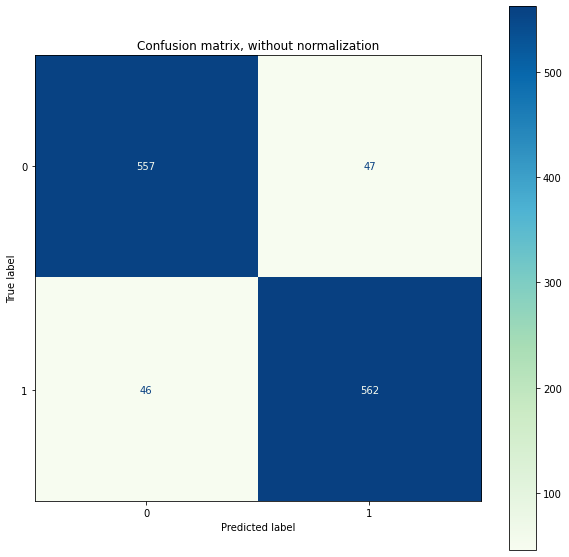

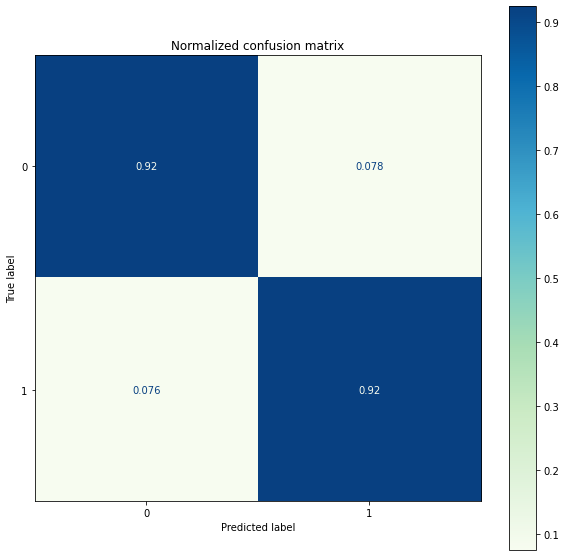

In [10]:
# Matriz sin normalizar y normalizada
titles_options = [("Confusion matrix, without normalization", None),
                      ("Normalized confusion matrix", 'true')]

for title, normalize in titles_options:
        fig, ax = plt.subplots(figsize=(10, 10))
        disp = ConfusionMatrixDisplay.from_predictions(y_test, CV_predictions,
                                                       cmap=plt.cm.GnBu,
                                                       normalize=normalize,
                                                       ax=ax)
        ax.set_title(title)

#### Curva ROC-AUC 

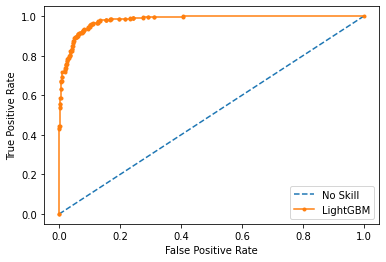

In [11]:
# Mantener probabilidades solo de los resultados positivos
yhat = CV_predict_proba[:, 1]
# Calcular roc curve
fpr, tpr, thresholds = roc_curve(y_test, yhat)
# Graficar roc curve para el modelo
plt.plot([0,1], [0,1], linestyle='--', label='No Skill')
plt.plot(fpr, tpr, marker='.', label='LightGBM')
# Leyenda de los ejes
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
# Mostrar el grafico
plt.show()

#### Curva Precision-Recall 

In [12]:
# Calcular pr-curve
precision, recall, thresholds = precision_recall_curve(y_test, yhat)

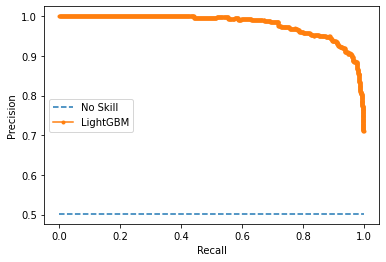

In [13]:
# Graficar pr-curve para el modelo
no_skill = len(y_test[y_test==1]) / len(y_test)
plt.plot([0,1], [no_skill,no_skill], linestyle='--', label='No Skill')
plt.plot(recall, precision, marker='.', label='LightGBM')
# Leyenda de los ejes
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend()
# Mostrar el grafico
plt.show()